<a href="https://colab.research.google.com/github/kayeekim00/kayeekim00.github.io/blob/master/_code_practice/Tensorflow_Time_Series_Prediction_KH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow Core Tutorial 따라하기 (KH Practice)

-. Tutorial 코딩을 재현 + 이해한 내용 주석이 추가되어있습니다 (keyword. kh)

-. Tutorial Link. https://www.tensorflow.org/tutorials/structured_data/time_series?hl=ko


이 튜토리얼에서는 TensorFlow를 사용한 시계열 예측을 소개합니다. Convolutional/Recurrent Neural Network(CNN 및 RNN)를 포함하여 몇 가지 다른 스타일의 모델을 빌드합니다.

이 내용은 각각 하위 항목이 있는 두 부분으로 나누어 생각합니다.

- 단일 타임스텝 예측:
    - 단일 특성
    - 모든 특성
- 다중 스텝 예측:
    - 싱글샷: 모두 한 번에 예측합니다.
    - 자가 회귀: 한 번에 하나의 예측을 수행하고 결과를 모델로 피드백합니다.

## Setting

In [53]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import plot_model # kh) keras 모델 시각화 

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


## Load Dataset

## 날씨 데이터세트

이 튜토리얼은 <a class="external" href="https://www.bgc-jena.mpg.de/wetter/">막스 플랑크 생물 지구화학 연구소</a>에서 기록한 <a class="external" href="https://www.bgc-jena.mpg.de">날씨 시계열 데이터세트</a>를 사용합니다.

이 데이터세트에는 온도, 대기압 및 습도와 같은 14가지 특성이 있습니다. 이러한 데이터는 2003년부터 시작해 10분 간격으로 수집되었습니다. 효율성을 위해 2009년과 2016년 사이에 수집된 데이터만 사용하겠습니다. 이 데이터세트 부분은 François Chollet이 자신이 저술한 책 [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)을 위해 준비했습니다.

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

이 튜토리얼은 **시간별 예측**만 다루므로 10분 간격부터 1시간까지 데이터를 서브 샘플링하는 것으로 시작합니다.

In [ ]:
df = pd.read_csv(csv_path)
display(df.head())

# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
display(df.head())
display(date_time.head())

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
Name: Date Time, dtype: datetime64[ns]

df[plot_cols][:480] - 처음 480개의 데이터만 plotting
KH- subplots = True/False 차이 확인하기


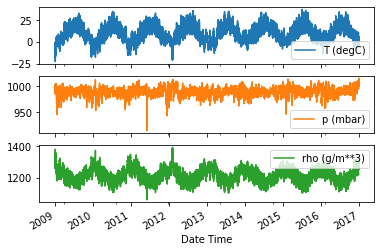

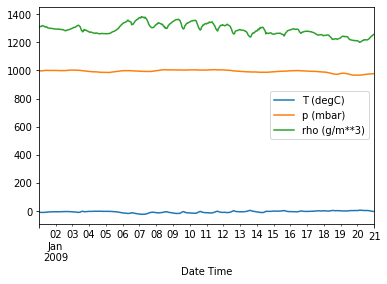

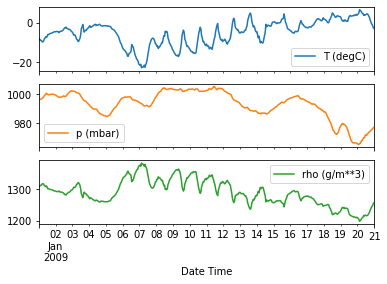

In [ ]:
# 시간에 따른 변수 Trend Plotting
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

print('df[plot_cols][:480] - 처음 480개의 데이터만 plotting')
print('KH- subplots = True/False 차이 확인하기')
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots = False)
_ = plot_features.plot(subplots = True)

## EDA & 전처리

## 검사 및 정리하기

*다음으로* 데이터세트의 통계를 살펴봅니다.

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


### 이상치 보정

#### 풍속

한 가지 주목할 점은 풍속의 `min` 값, `wv (m/s)` 및 `max. wv (m/s)` 열입니다. 이 `-9999`는 문제가 있는 것으로 보입니다. 별도의 풍향 열이 있으므로 속도는 `>=0`여야 합니다. 값을 0으로 대체합니다.


In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0 # kh) wv가 -9999.0 이면 true; 조건 값의 소속 여부를 Boolean 값으로 반환
print(bad_wv) # kh) 조건 값의 소속 여부를 Boolean 값으로 반환

wv[bad_wv] = 0.0 # kh) bad_wv = True 인 행 값을 -> 0.0 으로 대체

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0 
max_wv[bad_max_wv] = 0.0

# The above inplacer edits are reflected in the DataFrame
print(df['wv (m/s)'].min())

5         False
11        False
17        False
23        False
29        False
          ...  
420521    False
420527    False
420533    False
420539    False
420545    False
Name: wv (m/s), Length: 70091, dtype: bool
0.0


### 데이터 변환 - 변수화

### 특성 엔지니어링

모델을 본격적으로 빌드하기 전에 데이터를 이해하고 모델에 적절한 형식의 데이터를 전달하는 것이 중요합니다.

#### 바람

데이터의 마지막 열인 `wd (deg)`는 도 단위로 바람의 방향을 나타냅니다. 각도가 있으면 모델 입력으로 좋지 않으므로 360°와 0°는 서로 가까워야 하며 부드럽게 휘어져야 합니다. 바람이 불지 않으면 방향은 중요하지 않습니다.

현재, 바람 데이터의 분포는 다음과 같습니다.

Text(0, 0.5, 'Wind Velocity [m/s]')

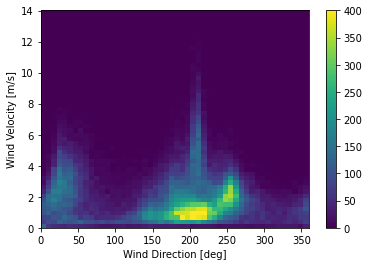

In [ ]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

그러나 풍향과 속도 열을 바람 **벡터**로 변환하면 모델이 해석하기가 더 쉽습니다.


In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

바람 벡터의 분포는 모델이 올바르게 해석하기에 훨씬 더 간단합니다.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

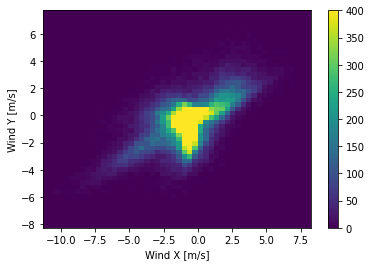

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### 시간

마찬가지로 `Date Time` 열은 매우 유용하지만 이 문자열 형식으로는 유용하지 않습니다. 우선 초로 변환합니다.

In [ ]:
print(datetime.datetime.timestamp) # kh check
print(date_time) # kh check

timestamp_s = date_time.map(datetime.datetime.timestamp)
print(timestamp_s)

<method 'timestamp' of 'datetime.datetime' objects>
5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]
5         1.230772e+09
11        1.230775e+09
17        1.230779e+09
23        1.230782e+09
29        1.230786e+09
              ...     
420521    1.483211e+09
420527    1.483215e+09
420533    1.483219e+09
420539    1.483222e+09
420545    1.483226e+09
Name: Date Time, Length: 70091, dtype: float64


##### 시간 -> 하루 및 연 단위의 주기성 변수로 변환  

풍향과 유사하게 초 단위의 시간은 유용한 모델 입력이 아닙니다. 날씨 데이터이므로 하루 및 연 단위의 주기성이 명확합니다. 주기성을 처리할 수 있는 방법에는 여러 가지가 있습니다.

사용 가능한 신호로 변환하는 간단한 방법은 `sin` 및 `cos`를 사용하여 시간을 명확한 "하루 중 시간" 및 "연중 시간" 신호로 변환하는 것입니다.

In [ ]:
day = 24*60*60 # kh) sec -> day: 24hr * 60min * 60sec
year = (365.2425)*day # kh) 통상적으로 사용되는 윤년을 고려한 avg days in year  = 365.2425 

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

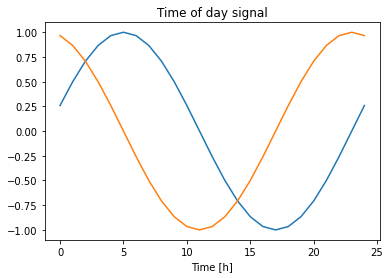

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

그러면 모델이 가장 중요한 빈도 특성에 액세스할 수 있습니다. 이 경우 어떤 빈도가 중요한지 미리 알고 있었습니다.

모르는 경우 `fft`를 사용하여 중요한 빈도를 결정할 수 있습니다. 시간에 따른 온도의 `tf.signal.rfft`를 보면 여기서 가정한 내용이 확인됩니다. `1/year` 및 `1/day` 근처에서 빈도 피크가 확실하다는 것을 알 수 있습니다. 

kh_check--------
original df['T (degC)'] 
 5    -8.05
11   -8.88
17   -8.81
23   -9.05
29   -9.63
Name: T (degC), dtype: float64
fft 
 [662393.7       +0.j      -4666.83  +37410.137j   -2705.8481+12410.741j
  12935.66   -1294.4241j -16647.074  +6837.21j  ]
f_per_dataset [    0     1     2 ... 35043 35044 35045]
------------


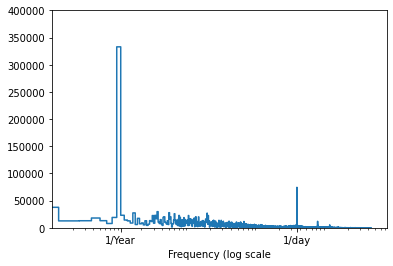

In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

print("kh_check--------")
print(f"original df['T (degC)'] \n {df['T (degC)'].head()}")
print(f"fft \n { fft[0:5] }")
print(f"f_per_dataset {f_per_dataset}")
print("------------")

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day']) # kh) matplotlib.pyplot.xticks(ticks=None, labels=None, **kwargs); Get or set the current tick locations and labels of the x-axis.
_ = plt.xlabel('Frequency (log scale')


### 데이터 분할 (train/val/test)

*훈련*, 검증 및 테스트 세트에 `(70%, 20%, 10%)` 분할을 사용합니다. 분할하기 전에 데이터가 임의로 셔플되지 **않습니다**. 이것은 두 가지 이유 때문입니다.

1. 데이터를 연속된 샘플의 창으로 자르는 것이 여전히 가능합니다.
2. 모델을 훈련한 후 수집된 데이터를 바탕으로 평가하므로 검증/테스트 결과가 보다 현실적입니다.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}
print("column_indices", column_indices) # kh check

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print("kh_check -------")
print("length of total dataset", n)
print("length of train_df, val_df, test_df", len(train_df), len(val_df), len(test_df))

column_indices {'p (mbar)': 0, 'T (degC)': 1, 'Tpot (K)': 2, 'Tdew (degC)': 3, 'rh (%)': 4, 'VPmax (mbar)': 5, 'VPact (mbar)': 6, 'VPdef (mbar)': 7, 'sh (g/kg)': 8, 'H2OC (mmol/mol)': 9, 'rho (g/m**3)': 10, 'Wx': 11, 'Wy': 12, 'max Wx': 13, 'max Wy': 14, 'Day sin': 15, 'Day cos': 16, 'Year sin': 17, 'Year cos': 18}
kh_check -------
length of total dataset 70091
length of train_df, val_df, test_df 49063 14018 7010


### 데이터 정규화

신경망을 훈련하기 전에 특성의 크기를 정하는 것이 중요합니다. 정규화는 이 크기 조정을 수행하는 일반적인 방법입니다. 평균을 빼고 각 특성의 표준 편차로 나눕니다.

모델이 검증 및 테스트 세트의 값에 액세스할 수 없도록 훈련 데이터를 사용해서만 평균 및 표준 편차를 계산해야 합니다.

----

또한 모델이 훈련할 때 훈련 세트의 미래 값에 액세스할 수 없어야 하고 이 정규화가 이동 평균을 사용하여 수행되어야 한다고 말할 수도 있습니다. 이 내용은 본 튜토리얼의 중점 사항이 아니며, 검증 및 테스트 세트가 있기 때문에 (다소) 정직한 메트릭을 얻을 수 있습니다. 따라서 단순화를 위해 이 튜토리얼에서는 단순 평균을 사용합니다.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

이제 특성의 분포를 살펴봅니다. 일부 특성은 꼬리가 길지만 `-9999` 풍속 값과 같은 명백한 오류는 없습니다.

,Column,Normalized
0,p (mbar),0.945308
1,p (mbar),0.959770
2,p (mbar),0.986284
3,p (mbar),1.004362
4,p (mbar),1.061006


kh Check - df.keys() Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy',
       'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')


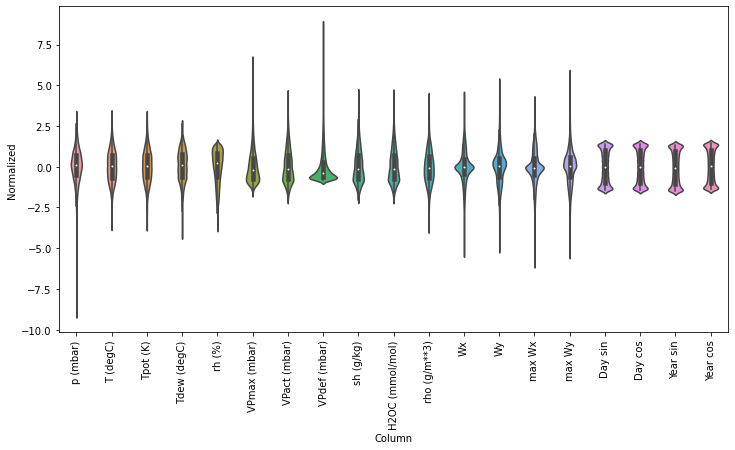

In [ ]:
df_std =  (df - train_mean) / train_std
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized') #kh ) pandas.melt: Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
display(df_std.head()) # kh check

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data = df_std)
_ = ax.set_xticklabels(df.keys(), rotation= 90)

print("kh Check - df.keys()", df.keys())

## 데이터 창 작업

이 튜토리얼의 모델은 데이터의 연속된 샘플 창을 기반으로 일련의 예측을 수행합니다.

입력 창의 주요 특성은 다음과 같습니다.

- 입력 및 레이블 창의 너비(타임스텝 수)
- 각 사이의 시간 오프셋
- 입력, 레이블 또는 둘 모두로 사용되는 특성

이 튜토리얼은 다양한 모델(선형, DNN, CNN 및 RNN 모델 포함)을 빌드하고 다음 두 가지 목적으로 이 모델을 사용합니다.

- *단일 출력* 및 *다중 출력* 예측
- *단일 타임스텝* 및 *다중 타임스텝* 예측

이 섹션에서는 모든 모델에 재사용할 수 있도록 데이터 창 작업을 구현하는 부분에 중점을 둡니다.

----

작업 및 모델 유형에 따라 다양한 데이터 창을 생성할 수 있습니다. 다음은 몇 가지 예입니다.

(kh - 예시그림은 원본 링크 참고; https://www.tensorflow.org/tutorials/structured_data/time_series?hl=ko)


1. 예를 들어, 24시간의 기록이 주어졌을 때 앞으로 24시간의 미래를 단일 예측하려면 다음과 같은 창을 정의할 수 있습니다.

![One prediction 24h into the future.](images/raw_window_24h.png)

(kh. 

* Input width = 24 (24시간의 기록이 주어졌을 때
* offset = 24 (앞으로 24시간의 미래를 ) , label width = 1 ( '단'일 예측하려면) (offset의 마지막 index 사용)
* total width = 48

)

1. 6시간의 기록이 주어졌을 때 앞으로 1시간의 미래를 예측하는 모델에는 다음과 같은 창이 필요합니다.

![One prediction 1h into the future.](images/raw_window_1h.png)

(kh. 

* Input width = 6 (6시간의 기록이 주어졌을 때
* offset = 1 (앞으로 1시간의 미래를 ) , label width = 1 ( '단'일 예측하려면) (offset의 마지막 index 사용)
* total width = 7

)

----

이 섹션의 나머지 부분에서는 `WindowGenerator` 클래스를 정의합니다. 이 클래스는 다음을 수행할 수 있습니다.

1. 위의 다이어그램과 같이 인덱스와 오프셋을 처리합니다.
2. 특성 창을 `(features, labels)` 쌍으로 분할합니다.
3. 결과 창의 내용을 플롯합니다.
4. `tf.data.Dataset`를 사용하여 훈련, 평가 및 테스트 데이터로부터 이러한 창을 여러 배치로 효율적으로 생성합니다.


### 1. 인덱스 및 오프셋

우선 `WindowGenerator` 클래스를 만듭니다. `__init__` 메서드에는 입력 및 레이블 인덱스에 필요한 모든 논리가 포함됩니다.

또한 train, eval 및 test 데이터 프레임을 입력으로 사용합니다. 이러한 데이터 프레임은 나중에 창의 `tf.data.Dataset`로 변환됩니다.

In [ ]:
"""
kh) [Python] 클래스 내장모듈 __repr__ (self)

__repr__: representation (표현하다)

__repr__ : 사용자가 객체 자체를 이해할 수 있게 표현해주는 메서드이다

추가사항 : __str__이 서로 다른 자료형 간 인터페이스를 제공하기 위한 목적으로 존재한다면, __repr__는 해당 객체를 인간이 이해할 수 있는 표현으로 나타내기 위한 용도이다.

출처: https://it-neicebee.tistory.com/104 [IT's Portfolio]
"""

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df = train_df, val_df = val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}

    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width) # kh) slice(start, stop[, step]); 잘라내기 원하는 index 들을 정의하는 클래스이다. Ref Link. https://technote.kr/255
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    

이 섹션의 시작 부분에서 다이어그램에 나타낸 두 개의 창을 만드는 코드는 다음과 같습니다.

In [ ]:
"""
(kh - 예시그림은 원본 링크 참고; https://www.tensorflow.org/tutorials/structured_data/time_series?hl=ko)

1. 예를 들어, 24시간의 기록이 주어졌을 때 앞으로 24시간의 미래를 단일 예측하려면 다음과 같은 창을 정의할 수 있습니다.

![One prediction 24h into the future.](images/raw_window_24h.png)

(kh. 

* Input width = 24 (24시간의 기록이 주어졌을 때
* offset = 24 (앞으로 24시간의 미래를 ) , label width = 1 ( '단'일 예측하려면) (offset의 마지막 index 사용)
* total width = 48

)
"""
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [ ]:
"""

2. 6시간의 기록이 주어졌을 때 앞으로 1시간의 미래를 예측하는 모델에는 다음과 같은 창이 필요합니다.

![One prediction 1h into the future.](images/raw_window_1h.png)

(kh. 

* Input width = 6 (6시간의 기록이 주어졌을 때
* offset = 1 (앞으로 1시간의 미래를 ) , label width = 1 ( '단'일 예측하려면) (offset의 마지막 index 사용)
* total width = 7

)
"""

w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. 분할

연속적인 입력 목록이 주어지면 `split_window` 메서드는 이 목록을 입력 창과 레이블 창으로 변환합니다.

위의 예제 `w2`는 다음과 같이 분할됩니다.

![The initial window is all consecuitive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/structured_data/images/split_window.png?raw=true)

이 다이어그램에는 데이터의 `features` 축이 나와 있지 않지만 이 `split_window` 함수는 단일 출력과 다중 출력 예에서 모두 사용될 수 있도록 `label_columns`를 처리합니다.

In [ ]:
def split_window(self, features):
  """
  kh) 
  Parameters
  ___
    -. features # 입력 목록이 주어지면

  Return
  ---
    -. inputs, labels # 입력 창과 레이블 창으로 변환
  """
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
    
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually, This way the 'tf.data.Datasets' are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

#kh) WindowGenerator 클래스에 split_window 내장함수 추가
WindowGenerator.split_window = split_window 

In [ ]:
## 다음을 사용해 보세요 (WindowGenerator.split_window 사용 예시)

# Stack three slices, the lenth of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


일반적으로 TensorFlow의 데이터는 가장 바깥 쪽 인덱스가 여러 예제("배치" 차원)에 걸쳐 있는 배열로 구성됩니다. 중간 인덱스는 "시간" 또는 "공간"(너비, 높이) 차원입니다. 가장 안쪽 인덱스는 특성입니다.

(kh

* 가장 바깥 쪽 인덱스 shape[0]: 여러 예제("배치" 차원)에 걸쳐 있는 배열로 구성; batch size
* 중간 인덱스 shape[1]:  "시간" 또는 "공간"(너비, 높이) 차원; time length
* 가장 안쪽 인덱스 shape[2]: 특성; # of column variables

)

위의 코드는 두 배치의 7-타임스텝 창을 사용하며 각 타임스텝에는 19개의 특성이 있습니다. 그러면 이것을 한 배치의 6-타임스텝과 19개의 특성 입력 및 1-타임스텝 1-특성 레이블로 분할합니다. 레이블에는 하나의 특성만 있는데, `WindowGenerator`가 `label_columns=['T (degC)']`로 초기화되었기 때문입니다. 우선 이 튜토리얼에서는 단일 출력 레이블을 예측하는 모델을 빌드합니다.

### 3. 플롯하기

다음은 분할 창을 간단하게 시각화할 수 있는 플롯 메서드입니다.

In [ ]:
w2.example = example_inputs, example_labels
print(w2.example) #kh check

(<tf.Tensor: shape=(3, 6, 19), dtype=float64, numpy=
array([[[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
         -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
         -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
         -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
          2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
          3.66110559e-01,  1.36606880e+00, -6.10523600e-02,
          1.42843408e+00],
        [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
         -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
         -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
         -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
          2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
          7.07199726e-01,  1.22479437e+00, -6.00293506e-02,
          1.42842359e+00],
        [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
         -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
         -1.52722507e+00, -7.88347960e-01, -1.5287026

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
      
    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')
  # -- end of def plot()  # kh added

WindowGenerator.plot = plot

이 플롯은 항목이 참조하는 시간을 기준으로 입력, 레이블 및 (나중에) 예측값을 정렬합니다.

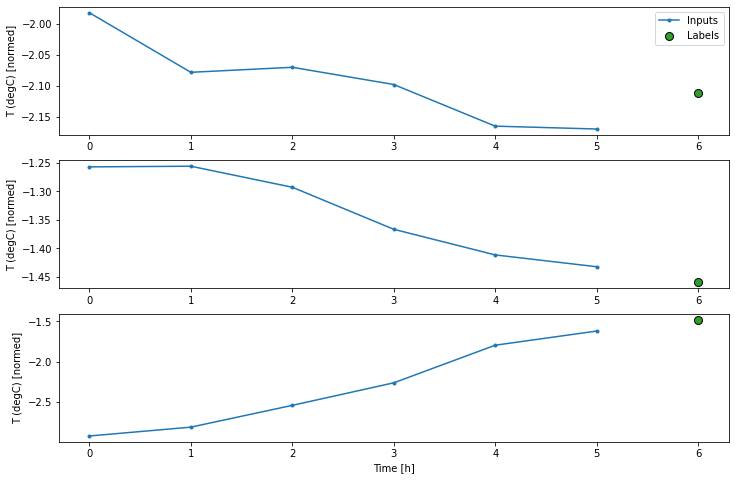

In [ ]:
w2.plot()

다른 열을 플롯할 수 있지만 예제 창 `w2` 구성에는 `T (degC)` 열에 대한 레이블만 있습니다.

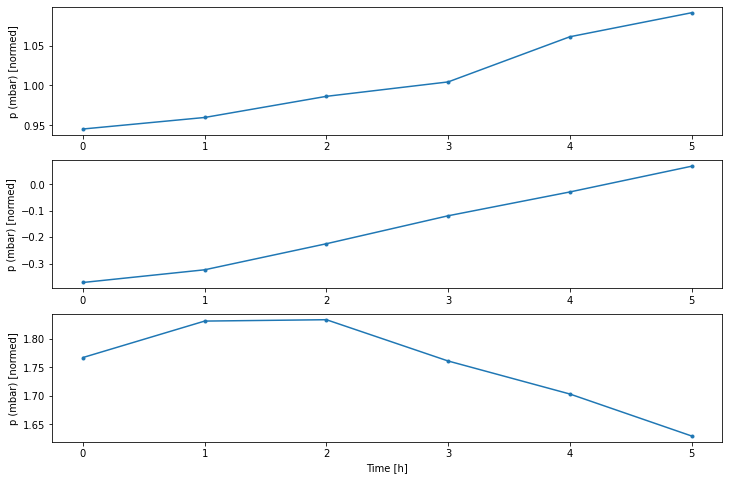

In [ ]:
w2.plot(plot_col='p (mbar)')

### 4. `tf.data.Dataset` 만들기

마지막으로, 이 `make_dataset` 메서드는 시계열 `DataFrame`을 가져와 `preprocessing.timeseries_dataset_from_array` 함수를 이용해 `(input_window, label_window)` 쌍의 `tf.data.Dataset`로 변환합니다.

In [ ]:
def make_dataset(self, data): 
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32, )
  
  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

`WindowGenerator` 객체는 훈련, 검증 및 테스트 데이터를 보유합니다. 위의 `make_dataset` 메서드를 사용하여 `tf.data.Datasets`로 여기에 액세스하기 위한 특성을 추가합니다. 또한 간편한 액세스와 플롯을 위한 표준 예제 배치를 추가합니다.

In [ ]:
"""
kh) @property

property 함수나 @property 데코레이터를 사용했을 때 가장 큰 이점은 외부에 티 내지 않고 

내부적으로 클래스의 필드 접근 방법을 바꿀 수 있다는 것

Ref LINK. https://www.daleseo.com/python-property/

==> kh) property(), @property:  getter, setter 없이 클래스 필드에 접근 가능 하게 함

"""

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of 'inputs, labels' for plotting."""
  result = getattr(self, '_example_', None)
  if result is None:
    # No example batch was found, so get one from the '.train' dataset
    result = next(iter(self.train))
    # ANd cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

이제 `WindowGenerator` 객체가 `tf.data.Dataset` 객체에 대한 액세스 권한을 부여하므로 데이터를 쉽게 반복할 수 있습니다.

`Dataset.element_spec` 속성은 데이터세트 요소의 구조, `dtypes` 및 형상을 알려줍니다.

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

`Dataset`를 반복하면 구체적인 배치가 생성됩니다.

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

print("\nkh check----")
print("w2.train.take(1)", w2.train.take(1))

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)

kh check----
w2.train.take(1) <TakeDataset element_spec=(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>


## 단일 스텝 모델

이러한 종류의 데이터를 기반으로 빌드할 수 있는 가장 간단한 모델은 현재 조건에만 기초하여 미래로 1 타임스텝(1시간) 진행된 단일 특성 값을 예측하는 모델입니다.

따라서 1시간 미래의 `T (degC)` 값을 예측하는 모델을 빌드하는 것으로 시작하겠습니다.

![Predict the next time step](images/narrow_window.png)


kh) Image LINK. https://www.tensorflow.org/tutorials/structured_data/images/narrow_window.png?hl=ko

----

다음과 같은 단일 스텝 `(input, label)` 쌍을 생성하도록 `WindowGenerator` 객체를 구성합니다.

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])

single_step_window


Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

`window` 객체는 훈련, 검증 및 테스트 세트로부터 `tf.data.Datasets`를 생성하므로 데이터 배치를 쉽게 반복할 수 있습니다.


In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### 기준 

(kh
* BaseLine 모델 빌드
* 제공되는 tf.keras.Model 을 기준 모델로 사용

)

훈련 가능한 모델을 빌드하기 전에 나중에 더 복잡한 모델과 비교하기 위한 포인트로 성능 기준을 갖는 것이 좋습니다.

첫 번째 작업은 모든 특성의 현재 값을 고려하여 1시간 미래의 온도를 예측하는 것입니다. 현재 값에는 현재 온도가 포함됩니다.

따라서 예측으로 현재 온도를 반환하여 "변화 없음"을 예측하는 모델로 시작하겠습니다. 온도는 천천히 변하기 때문에 이것은 합리적인 기준입니다. 물론, 더 미래로 들어가면 이 기준의 예측 효과는 떨어질 것입니다.

![Send the input to the output](images/baseline.png)

kh IMAGE LINK. https://www.tensorflow.org/tutorials/structured_data/images/baseline.png?hl=ko

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]
    

이 모델을 인스턴스화하고 평가합니다.

In [ ]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=tf.metrics.MeanAbsoluteError())

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

print("kh check---")
print("baseline", baseline) # kh-check
print("val_performance, performance", val_performance, performance) #kh-check


439/439 [==============================] - 4s 9ms/step - loss: 0.0128 - mean_absolute_error: 0.0785
kh check---
baseline <__main__.Baseline object at 0x7f02017c0b50>
val_performance, performance {'Baseline': [0.012845640070736408, 0.07846628874540329]} {'Baseline': [0.014162620529532433, 0.08516015112400055]}


몇 가지 성능 메트릭을 출력했지만 모델이 얼마나 잘 동작하는지에 대한 느낌은 주지 않습니다.

`WindowGenerator`에는 플롯 메서드가 있지만 단일 샘플만으로는 플롯이 그다지 흥미롭지 않습니다. 따라서 한 번에 24시간 범위의 연속 입력과 레이블을 생성하는 더 넓은 `WindowGenerator`를 만듭니다.

`wide_window`는 모델이 동작하는 방식을 변화시키지 않습니다. 이 모델은 단일 입력 타임스텝을 기반으로 1시간 미래를 예측합니다. 여기서 `time` 축은 `batch` 축과 같은 역할을 합니다. 각 예측은 타임스텝 사이의 상호 작용 없이 독립적으로 이루어집니다.

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

이 확장된 창은 어떠한 코드 변경 없이 동일한 `baseline` 모델에 직접 전달할 수 있습니다. 이는 입력과 레이블이 동일한 수의 타임스텝을 가지며 기준이 입력을 출력으로 전달하기 때문에 가능합니다.

![One prediction 1h into the future, ever hour.](images/last_window.png)

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


기준 모델의 예측값을 플롯하면 1시간씩 오른쪽으로 이동한 단순한 레이블임을 알 수 있습니다.

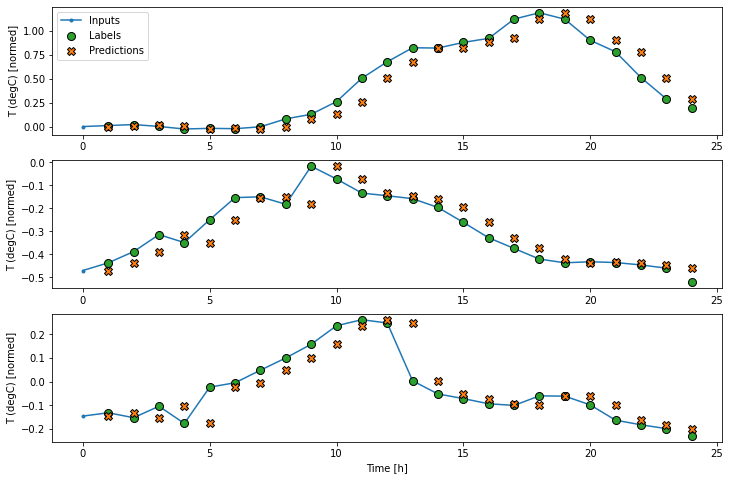

In [ ]:
wide_window.plot(baseline)

위의 세 가지 예제 플롯에서 단일 스텝 모델은 24시간 동안 실행됩니다. 이에 관해 몇 가지 설명이 필요합니다.

- 파란색 "입력" 라인은 각 타임스텝의 입력 온도를 보여줍니다. 이 모델은 모든 특성을 수신하며 이 플롯은 온도만 표시합니다.
- 녹색 "레이블" 점은 목표 예측값을 나타냅니다. 이러한 점은 입력 시간이 아니라 예측 시간에 표시됩니다. 레이블의 범위가 입력에 상대적으로 한 스텝 이동하는 이유가 여기에 있습니다.
- 주황색 "예측" 십자는 각 출력 타임스텝에 대한 모델의 예측입니다. 모델이 완벽하게 예측하는 경우 예측값은 "레이블" 바로 위에 놓여집니다.

### 선형 모델

이 작업에 적용할 수 있는 가장 간단한 **훈련 가능한** 모델은 입력과 출력 사이에 선형 변환을 삽입하는 것입니다. 이 경우 타임스텝의 출력은 해당 스텝에만 의존합니다.

![A single step prediction](images/narrow_window.png)

`activation` 세트가 없는 `layers.Dense`는 선형 모델입니다. 레이어는 데이터의 마지막 축을 `(batch, time, inputs)`에서 `(batch, time, units)`로만 변환하며, `batch` 및 `time` 축의 모든 항목에 독립적으로 적용됩니다.

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


#### Training 함수 만들기

이 튜토리얼은 많은 모델을 훈련하므로 훈련 절차를 하나의 함수 패키지로 만듭니다.

In [ ]:
MAX_EPOCHS = 5

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
## 모델을 훈련하고 성능을 평가합니다.

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

print("kh check---")
print("Linear", linear) # kh-check
print("val_performance", val_performance) #kh-check
print("performance", performance) #kh-check

Epoch 1/20
1534/1534 [==============================] - 16s 10ms/step - loss: 0.4326 - mean_absolute_error: 0.3925 - val_loss: 0.0405 - val_mean_absolute_error: 0.1513
Epoch 2/20
1534/1534 [==============================] - 15s 9ms/step - loss: 0.0218 - mean_absolute_error: 0.1115 - val_loss: 0.0116 - val_mean_absolute_error: 0.0802
Epoch 3/20
1534/1534 [==============================] - 15s 10ms/step - loss: 0.0101 - mean_absolute_error: 0.0746 - val_loss: 0.0087 - val_mean_absolute_error: 0.0683
Epoch 4/20
1534/1534 [==============================] - 16s 10ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0086 - val_mean_absolute_error: 0.0679
Epoch 5/20
1534/1534 [==============================] - 15s 9ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0086 - val_mean_absolute_error: 0.0673
Epoch 6/20
1534/1534 [==============================] - 19s 12ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0085 - val_mean_absolute_error: 0

`baseline` 모델과 마찬가지로 선형 모델은 넓은 범위의 배치에서 호출할 수 있습니다. 이러한 방식으로 모델은 연속적인 타임스텝에 대해 일련의 독립적인 예측을 수행합니다. `time` 축은 다른 `batch` 축처럼 작동합니다. 각 타임스텝에서 예측 사이에 상호 작용은 없습니다.

![A single step prediction](images/wide_window.png)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


다음은 `wide_widow`에 대한 예제 예측값을 플롯한 내용입니다. 많은 경우 예측이 단순히 입력 온도를 반환하는 것보다는 분명히 더 낮지만 몇 가지 경우에는 더 나쁘다는 사실에 주목하세요.

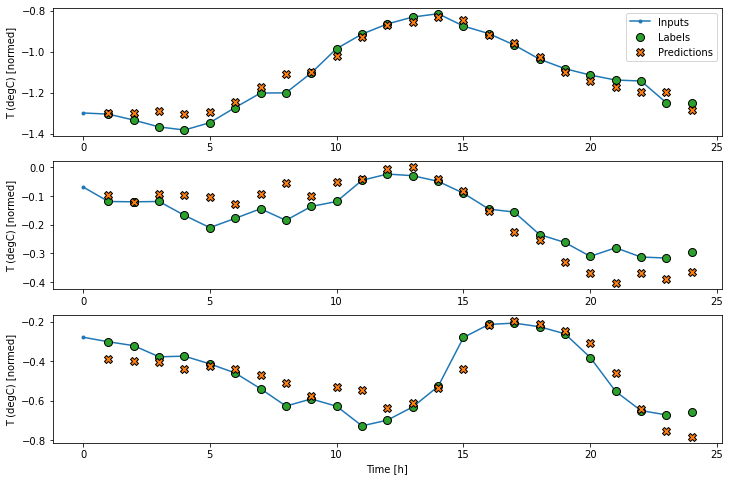

In [ ]:
wide_window.plot(linear)

#### Linear 모델 해석 - Linear 모델의 가중치 가져오기 
선형 모델의 한 가지 장점은 해석하기가 상대적으로 간단하다는 것입니다. 레이어의 가중치를 가져와 각 입력에 할당된 가중치를 볼 수 있습니다.

kh check---
[[ 1.7976382e-01]
 [ 3.2778519e-01]
 [ 4.4595923e-02]
 [-7.9864554e-02]
 [ 3.8219649e-02]
 [ 1.4331529e-01]
 [-6.2604576e-02]
 [-6.4536095e-02]
 [ 1.5413145e-02]
 [ 5.1153690e-04]
 [-6.7973697e-01]
 [ 4.8075421e-03]
 [-1.8081620e-03]
 [-1.8796587e-02]
 [ 1.8348318e-02]
 [ 3.6073193e-02]
 [-5.2411981e-02]
 [ 4.2632245e-03]
 [-1.8240711e-02]]
[ 1.7976382e-01  3.2778519e-01  4.4595923e-02 -7.9864554e-02
  3.8219649e-02  1.4331529e-01 -6.2604576e-02 -6.4536095e-02
  1.5413145e-02  5.1153690e-04 -6.7973697e-01  4.8075421e-03
 -1.8081620e-03 -1.8796587e-02  1.8348318e-02  3.6073193e-02
 -5.2411981e-02  4.2632245e-03 -1.8240711e-02]


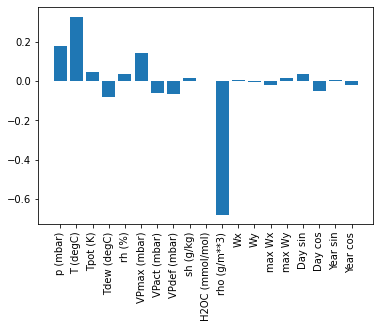

In [ ]:
"""
kh) tensorflow 모델 가중치 조회하기
{tf_model}.layers[{n}].kernel.numpy() 를 통해 n번째 layer의 kernel (weight matrix) 에 접근가능

"""
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis=plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

print("kh check---")
print(linear.layers[0].kernel.numpy())
print(linear.layers[0].kernel[:,0].numpy())

때로 모델은 입력 `T (degC)`에 가장 많은 가중치를 두지 않습니다. 이것은 무작위 초기화의 위험 중 하나입니다. 

### 밀집
### (kh- Deep 하게 쌓기)

실제로 여러 타임스텝에서 동작하는 모델을 적용하기 전에 더 깊고 강력한 단일 입력 스텝 모델의 성능을 확인하는 것이 좋습니다.

다음 모델은 입력과 출력 사이에 몇 개의 `Dense` 레이어를 쌓는다는 점을 제외하면 `linear` 모델과 유사합니다. 

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/5
1534/1534 [==============================] - 34s 20ms/step - loss: 0.0158 - mean_absolute_error: 0.0804 - val_loss: 0.0080 - val_mean_absolute_error: 0.0652
Epoch 2/5
1534/1534 [==============================] - 28s 18ms/step - loss: 0.0080 - mean_absolute_error: 0.0650 - val_loss: 0.0072 - val_mean_absolute_error: 0.0614
Epoch 3/5
1534/1534 [==============================] - 22s 14ms/step - loss: 0.0075 - mean_absolute_error: 0.0625 - val_loss: 0.0070 - val_mean_absolute_error: 0.0595
Epoch 4/5
1534/1534 [==============================] - 27s 17ms/step - loss: 0.0073 - mean_absolute_error: 0.0612 - val_loss: 0.0070 - val_mean_absolute_error: 0.0603
Epoch 5/5
439/439 [==============================] - 5s 11ms/step - loss: 0.0067 - mean_absolute_error: 0.0581


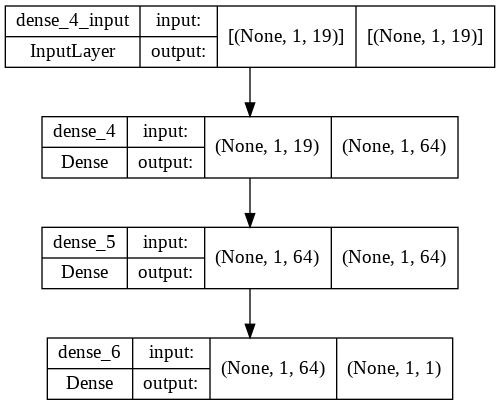

In [54]:
# kh) 모델 시각화 하기 
plot_model(dense, show_shapes=True)

### 다중 스텝 밀집

단일 타임스텝 모델에는 입력의 현재 값에 대한 컨텍스트가 없습니다. 시간에 따라 입력 특성이 어떻게 변하는지 볼 수 없습니다. 이 문제를 해결하려면 모델이 예측을 수행할 때 여러 타임스텝에 액세스해야 합니다.

![Three time steps are used for each prediction.](images/conv_window.png)


`baseline` , `linear` 및 `dense` 모델은 각 타임스텝을 독립적으로 처리했습니다. 여기서 모델은 단일 출력을 생성하기 위해 여러 타임스텝을 입력으로 사용합니다.

3시간의 입력과 1시간의 레이블 배치를 생성하는 `WindowGenerator`를 만듭니다.

`Window`의 `shift` 매개변수는 두 창의 끝에 상대적입니다.


In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

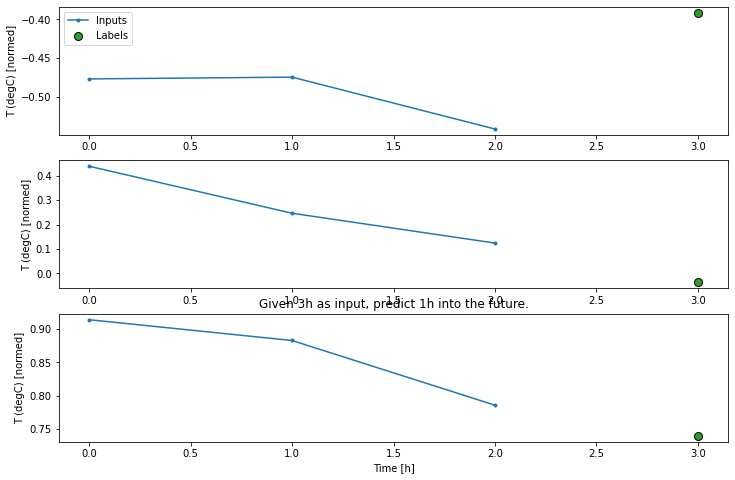

In [ ]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

`layers.Flatten`을 모델의 첫 번째 레이어로 추가하여 다중 입력 스텝 창에서 `dense` 모델을 훈련할 수 있습니다.

In [56]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [57]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [58]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output() # kh) display 되는 결과 중 마지막 쪽 결과만 display 되도록 설정
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 4s 9ms/step - loss: 0.0075 - mean_absolute_error: 0.0641


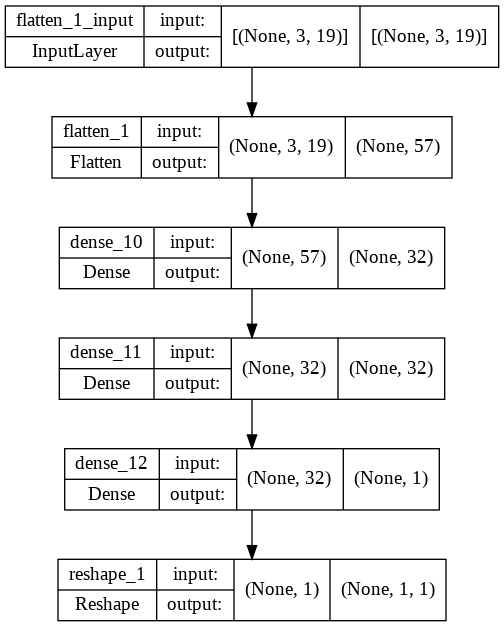

In [59]:
plot_model(multi_step_dense, show_shapes=True) # kh) 모델 시각화 하기 

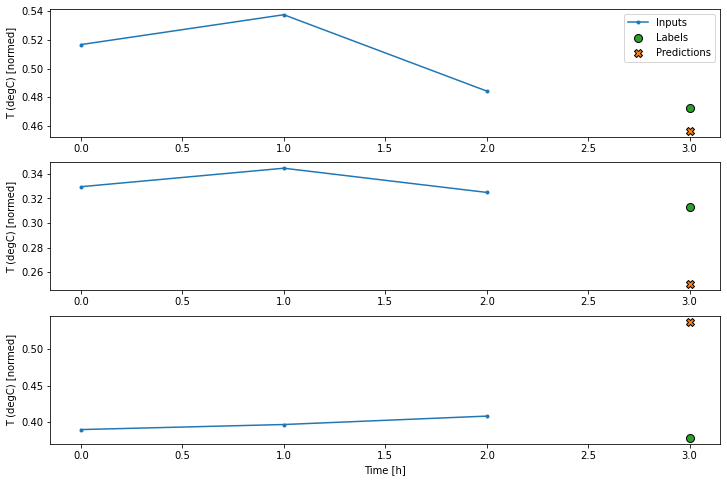

In [61]:
conv_window.plot(multi_step_dense)


이 접근법의 주된 단점은 결과적인 모델이 정확히 이 형상의 입력 창에서만 실행될 수 있다는 것입니다. 

In [62]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling layer "sequential_4" (type Sequential).

Input 0 of layer "dense_10" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received:
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


다음 섹션의 컨볼루셔널 모델은 이 문제를 해결합니다.

### 컨볼루션 신경망

컨볼루션 레이어(`layers.Conv1D`)도 각 예측에 대한 입력으로 여러 타임스텝을 사용합니다.

다음은 컨볼루션으로 다시 작성한 `multi_step_dense`와 **동일한** 모델입니다.

다음 변경 사항에 주목하세요.

- `layers.Flatten`과 첫 번째 `layers.Dense`는 `layers.Conv1D`로 대체됩니다.
- 컨볼루션이 출력에서 시간 축을 유지하므로 `layers.Reshape`는 이 더 이상 필요하지 않습니다.

In [63]:
"""
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
"""
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

예제 배치에서 실행하여 모델이 예상된 형상으로 출력을 생성하는지 확인합니다.

In [64]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


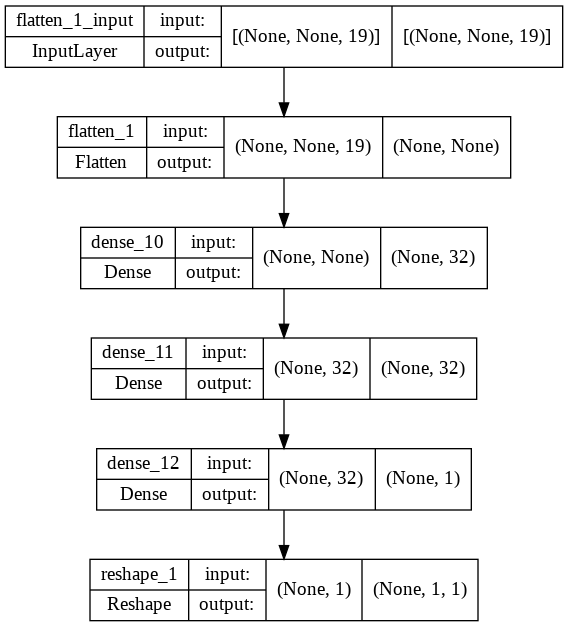

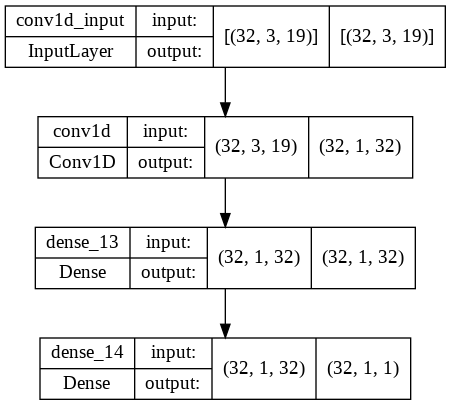

In [68]:
#kh) multi_step_dense vs conv_model
display(plot_model(multi_step_dense, show_shapes=True)) # kh) 모델 시각화 하기 
display(plot_model(conv_model, show_shapes=True)) # kh) 모델 시각화 하기 

`conv_window`에서 훈련하고 평가하면 `multi_step_dense` 모델과 유사한 성능을 제공해야 합니다.

In [69]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 5s 10ms/step - loss: 0.0065 - mean_absolute_error: 0.0571


이 `conv_model`과 `multi_step_dense` 모델의 차이점은 `conv_model`은 모든 길이의 입력에서 실행될 수 있다는 것입니다. 컨볼루셔널 레이어는 입력의 슬라이딩 윈도우에 적용됩니다.

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

더 넓은 입력에서 실행하면 더 넓은 출력이 생성됩니다.

In [70]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape) # kh) 모델의 output shape

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


출력은 입력보다 짧습니다. 훈련 또는 플롯 작업을 수행하려면 레이블과 예상의 길이가 동일해야 합니다. 따라서 레이블과 예측 길이가 일치하도록 몇 개의 추가 입력 타임스텝으로 넓은 창을 생성하는 `WindowGenerator`를 빌드합니다. 

In [71]:
#kh) Labels shape = Output shape 가 되도록 window 생성
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [74]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [73]:
# kh) wide_window vs wide_conv_window
display(wide_window)
display(wide_conv_window)

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

이제 더 넓은 창에 모델의 예측값을 플롯할 수 있습니다. 첫 번째 예측 전 3개의 입력 타임스텝에 주목하세요. 여기서 모든 예측은 이전 3개의 타임스텝에 기초합니다.

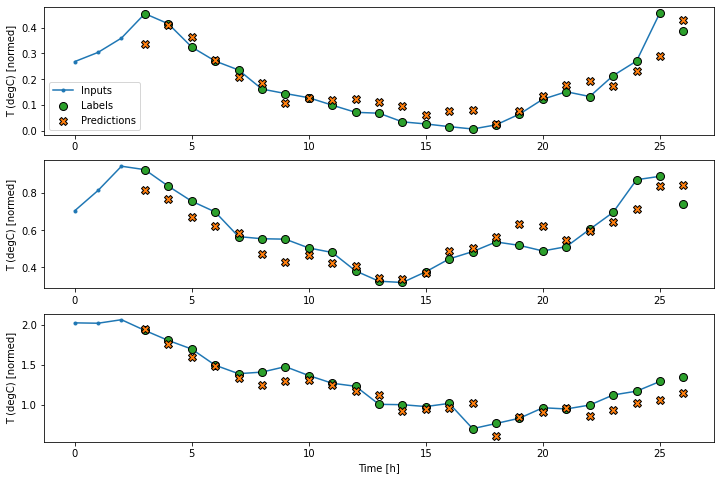

In [75]:
wide_conv_window.plot(conv_model)

### 순환 신경망

Recurrent Neural Network(RNN)는 시계열 데이터에 적합한 신경망 유형입니다. RNN은 시계열을 단계별로 처리하여 타임스텝 사이에서 내부 상태를 유지합니다.

자세한 내용은 [텍스트 생성 튜토리얼](https://www.tensorflow.org/tutorials/text/text_generation) 또는 [RNN 가이드](https://www.tensorflow.org/guide/keras/rnn)를 읽어보세요.

이 튜토리얼에서는 [Long Short Term Memory](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)(LSTM)이라는 RNN 레이어를 사용합니다.

모든 keras RNN 레이어에 대한 중요한 생성자 인수는 `return_sequences` 인수입니다. 이 설정은 다음 두 가지 방법 중 하나로 레이어를 구성할 수 있습니다.

1. 기본값인 `False`인 경우 레이어는 최종 타임스텝의 출력만 반환하여 단일 예측을 수행하기 전에 모델이 내부 상태를 준비할 시간을 줍니다.

![An lstm warming up and making a single prediction](images/lstm_1_window.png)

1. `True`이면 레이어가 각 입력에 대한 출력을 반환합니다. 다음과 같은 경우에 유용합니다.

- RNN 레이어 쌓기
- 여러 타임스텝에서 동시에 모델 훈련

![An lstm making a prediction after every timestep](images/lstm_many_window.png)


(kh
* Input 의 time_length = 24 인 경우,
* return_sequence=False: input (t=1, ..,, 24) /output ( t=24)
* return_sequence=True: input (t=1, ..,, 24) /output ( t=1, ..., 24). 시점마다 대응되는 output 반환

)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [`  ]                                    
])

In [ ]:
plot_model(multi_step_dense, show_shapes=True) # kh) 모델 시각화 하기 